In [5]:
from timbr import Snapshot
%reload_ext timbr.notebook
%timbr SnapshotSelector

<IPython.core.display.Javascript object>

In [6]:
data = Snapshot("/Users/seangorman/.timbr/data/steamboat_christiecam.h5")

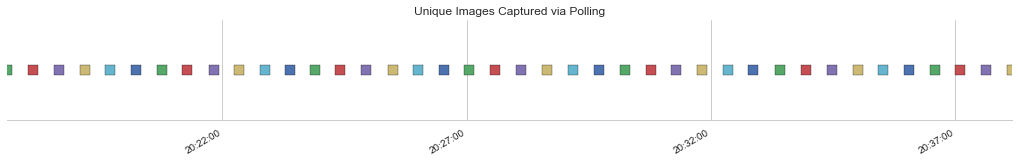

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import timedelta
from bson import ObjectId
import seaborn as sns
sns.set_style('whitegrid')
from itertools import cycle
cyclic_palette = cycle(sns.color_palette())
values = []
X = [ObjectId(oid).generation_time for oid, rec in data][:40]
ref = ""
current_color = cyclic_palette.next()
for oid, rec in data:
    if rec['media']['__data__'] != ref:
        current_color = cyclic_palette.next()
    values.append(current_color)
    ref = rec['media']['__data__']

values = values[:40]
    
fig, ax = plt.subplots(figsize=(18,2))
ax.scatter(X, [1]*len(X), c=values,
           marker='s', s=100)
fig.autofmt_xdate()

# everything after this is turning off stuff that's plotted by default

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.get_yaxis().set_ticklabels([])
interval = timedelta(minutes=0)
plt.xlim(X[0] - interval, X[-1] + interval)
plt.title("Unique Images Captured via Polling")
plt.show()

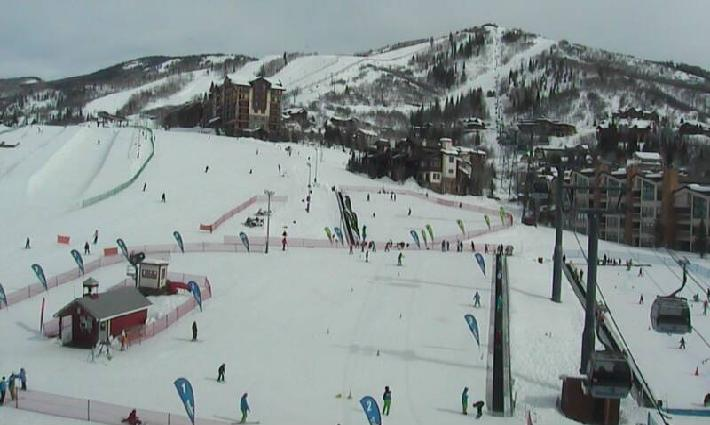

In [10]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import Image, display
import base64 as b64

@interact(i=widgets.IntSlider(min=0,max=len(data)-1,step=1,value=0))
def f(i):
    display(Image(data=b64.b64decode(data[i][-1]["media"]["__data__"])))

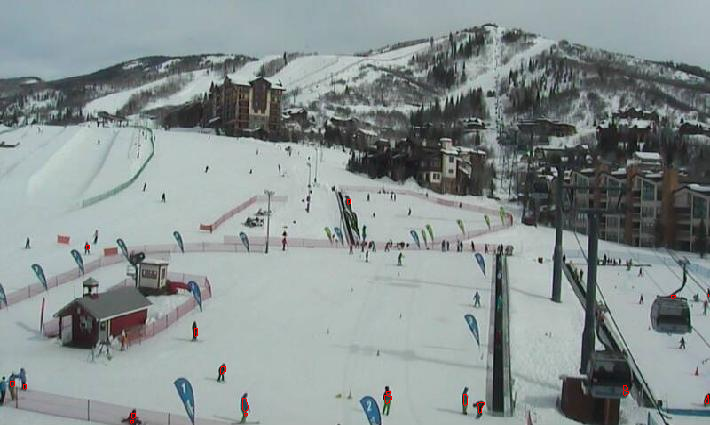

17 'people' found


In [12]:
import base64 as b64
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from IPython.display import Image, display
import ipywidgets as widgets

def convert_media_to_image(media):
    arr = np.asarray(bytearray(b64.b64decode(media["__data__"])), dtype=np.uint8)
    return cv2.imdecode(arr,-1)

history = 50
nGauss = 2
bgThresh = 0.75
noise = 20

fgbg = cv2.BackgroundSubtractorMOG(history, nGauss, bgThresh, noise)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))

def preprocess(image, ref):
    fgmask = fgbg.apply(image)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    return fgmask

def display_image(image):
    _, png_image = cv2.imencode(".png", image)
    display(Image(data=png_image.tostring()))

images = [convert_media_to_image(rec["media"]) for oid, rec in data]
shape = list(images[0].shape)
shape.append(min(len(images), 100))
avg = np.zeros(shape)
for z, image in enumerate(images[:100]):
    avg[:,:,:,z] = image
avg = np.uint8(np.average(avg, axis=3))
avg = cv2.merge([avg[:,:,0],avg[:,:,1],avg[:,:,2]])
fgbg.apply(avg)
preprocessed = [preprocess(img, avg) for img in images]
cv2.imwrite("avg.jpg", avg)
@interact(idx=widgets.IntSlider(min=0,max=len(images)-1,step=1,value=0))
def display_contours(idx):
    contours, _ = cv2.findContours(preprocessed[idx],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    good_contours = [c for c, a in zip(contours, areas) if a < 200]
    cv2.drawContours(images[idx], good_contours, -1, (0, 0, 255))
    display_image(images[idx])
    print "%i 'people' found" % len(good_contours)
